In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import itertools

In [2]:
# Importing the data
df = pd.read_csv('sampledata_20190313.csv', header=None)
df.columns = ['a', 'b']
df.head()

,a,b
0,5.40230,-7.1490
1,-7.34510,15.2730
2,8.75070,-5.9696
3,-14.04800,17.6710
4,0.24255,6.8476


We can see that there are bivariate gaussian clusters and a few anomalies
The northwest cluster looks like it might be composed of 2 gaussian clusters
The distributions appear to be aligned with the axis.
Alignment implies the variables are independant and therefore would exhibit no covariation.


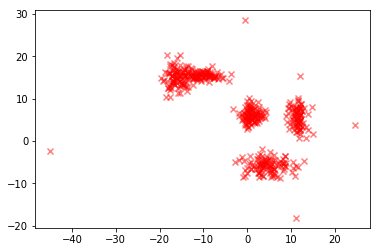

In [3]:
plt.scatter(df['a'].values, df['b'].values, c='r', alpha=0.5, marker='x')
print('We can see that there are bivariate gaussian clusters and a few anomalies')
print('The northwest cluster looks like it might be composed of 2 gaussian clusters')
print('The distributions appear to be aligned with the axis.')
print('Alignment implies the variables are independant and therefore would exhibit no covariation.')

In [4]:
# remove the 4 extreme outliers:
df = df[(df['a'] > -30) & (df['a'] < 20) & (df['b'] < 25) & (df['b'] > -15)]

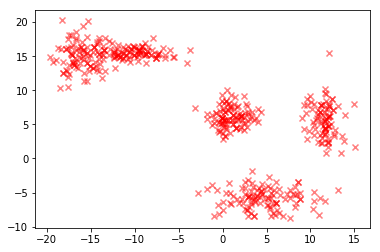

In [5]:
plt.scatter(df['a'].values, df['b'].values, c='r', alpha=0.5, marker='x')


Zoom in to the middle cluster
The markers have transparency, so you can see duplicted points as darker crosses


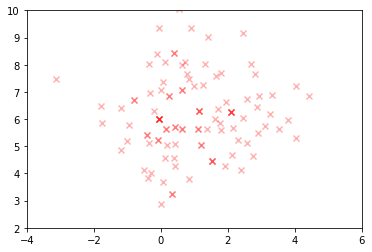

In [6]:
plt.xlim(-4,6)
plt.ylim(2,10)
plt.scatter(df['a'].values, df['b'].values, c='r', alpha=0.3, marker='x')
print('\nZoom in to the middle cluster')
print('The markers have transparency, so you can see duplicted points as darker crosses')

In [7]:
print(df[df.duplicated()].count())
print('Indeed there are duplicates')

a    94
b    94
dtype: int64
Indeed there are duplicates


In [8]:
df[df['a'] == -15.397000]

,a,b
15,-15.397,15.403
53,-15.397,15.403


In [9]:
# ^ Example of a duplicate

In [10]:
print('Remove duplicates')
df = df.drop_duplicates()

Remove duplicates


In [11]:
df.shape

(402, 2)

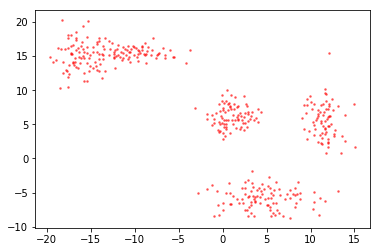

In [12]:
plt.scatter(df['a'].values, df['b'].values, c='r', alpha=0.5, marker='.', s=10)

In [13]:
# Q.2. Use a clustering algorithm of your choice to group the data. Does your algorithm require the
# number of clusters or distance measure to be defined? If so, how do you initialize these?

Looking at the data, I would assume there are 5 distributions (2 for the northwest)
And axis-alignment would suggest covariance type diagonal can be initialised
However we can test these assumptions...


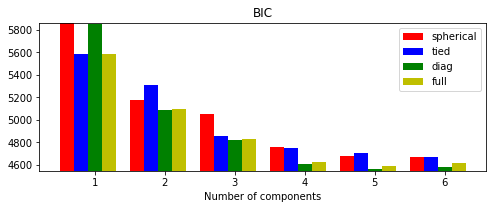

In [14]:
print('Looking at the data, I would assume there are 5 distributions (2 for the northwest)')
print('And axis-alignment would suggest covariance type diagonal can be initialised')
print('However we can test these assumptions...')

X = df.values 
lowest_bic = np.inf
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type, n_init=10)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
bic = np.array(bic)
color_iter = itertools.cycle(['r', 'b', 'g','y'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [15]:
print('Using the bayesian information criterion as a metric suggests that assuming 5 gaussian+diagonal components fits the data best')

Using the bayesian information criterion as a metric suggests that assuming 5 gaussian+diagonal components fits the data best


gmm converged: True
Predicted clusters:


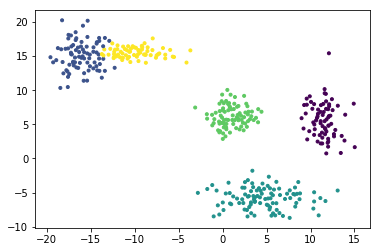

In [16]:
gmm = GaussianMixture(n_components=5, covariance_type='diag', n_init=100)
gmm.fit(X)
print('gmm converged:', gmm.converged_)
print('Predicted clusters:')
predicted_labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=predicted_labels, alpha=1, marker='.')

Contours and means:


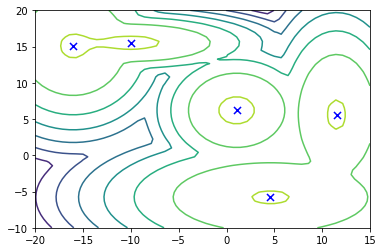

In [17]:
D, E = np.meshgrid(np.linspace(-20, 15), np.linspace(-10,20))
DD = np.array([D.ravel(), E.ravel()]).T
F = gmm.score_samples(DD)
F = F.reshape(50,50)
print('Contours and means:')
plt.scatter(gmm.means_[:,0], gmm.means_[:, 1], c='b', alpha=1, marker='x', s = 50)
plt.contour(D, E, F)

In [18]:
# Q.3. Find the mean of each cluster.

In [19]:
gmm.means_

array([[ 11.49979504,   5.61486535],
       [-16.02066259,  15.04548208],
       [  4.59573942,  -5.8053446 ],
       [  1.0510037 ,   6.20939491],
       [-10.00779485,  15.51855351]])

In [20]:
# Q.4. Find the covariance matrix for each cluster. Explain what the covariance matrix represents. 

In [21]:
for i in range(5):
    X_cluster = df[predicted_labels == i].values
    print(np.around(np.cov(X_cluster.T), 3), '\n')

[[ 1.511 -0.493]
 [-0.493  6.552]] 

[[2.6   0.116]
 [0.116 4.373]] 

[[10.079 -0.188]
 [-0.188  2.23 ]] 

[[2.219 0.117]
 [0.117 2.297]] 

[[ 5.215 -0.147]
 [-0.147  0.533]] 



In [22]:
print('Covariance is a measure of how changes in one variable are associated with changes in another variable.')
print('Because cov(i,j) == cov(j,i); every covariance matrix is symmetric.')
print('Each diagonal element represents the variance of its respective random variable.')
print('For example, the middle matrix corresonds to the south cluster, it has diagonal elements: 10.0, 2.2')
print('this explains why the cluster is wider than it is tall.')
print('These covariance matrices are almost diagonal ie. their off-diagonal values are close to 0.')
print('This suggests that the random variables are independent, and explains why the distributions appear to be axis-aligned.')

Covariance is a measure of how changes in one variable are associated with changes in another variable.
Because cov(i,j) == cov(j,i); every covariance matrix is symmetric.
Each diagonal element represents the variance of its respective random variable.
For example, the middle matrix corresonds to the south cluster, it has diagonal elements: 10.0, 2.2
this explains why the cluster is wider than it is tall.
These covariance matrices are almost diagonal ie. their off-diagonal values are close to 0.
This suggests that the random variables are independent, and explains why the distributions appear to be axis-aligned.


In [23]:
# Q.5. How well does the model perform? How would you validate your model given more data points? 
print('Measuring the performance of a unsupervised (no ground truth labels) data is hard.')
print('We can use the Bayesian information criterion and Akaike information criterion measures to compare models.')
print('With more data points, we can fit new gmm models and ensure the BIC/AIC fall.')
print('The Silhouette Coefficient is another metric used to validate unsupervised learning.')
print('Finally, sklearn provides us with a way to generate new labelled data from our trained model,')
print('transforming the problem into a supervised problem. Eg:\n')
for i in range(10):
    point, component = gmm.sample()
    print('label:', component[0], np.around(point[0], decimals=1))

Measuring the performance of a unsupervised (no ground truth labels) data is hard.
We can use the Bayesian information criterion and Akaike information criterion measures to compare models.
With more data points, we can fit new gmm models and ensure the BIC/AIC fall.
The Silhouette Coefficient is another metric used to validate unsupervised learning.
Finally, sklearn provides us with a way to generate new labelled data from our trained model,
transforming the problem into a supervised problem. Eg:

label: 4 [-9.7 15.6]
label: 3 [1.2 3.7]
label: 4 [-11.6  16.3]
label: 0 [11.3  6.4]
label: 2 [ 8. -9.]
label: 2 [ 7.5 -5.1]
label: 0 [11.   9.7]
label: 2 [ 6.3 -7.2]
label: 3 [2.5 7.6]
label: 3 [0.  4.3]


In [24]:
# Q.6. Generate a sample of points from a mixture of two 3D multivariate Gaussian distributions. 
# Plot your sample points. Repeat your clustering analysis. 
# Q. 7. Generalize your code to be able to generate a sample of a mixture of N 3D multivariate Gaussian
# distributions. (N should be configurable by a simple parameter near the top of your script.) 

In [25]:
N = 2 # number of clusters
number_of_observations = 1000
np.random.seed(42)

In [26]:
# generate weights 
weights = [] 
probability_remaining = 1
for _ in range(0,N-1):
    weight = np.random.uniform(0,probability_remaining/2)
    probability_remaining-=weight
    weights.append(weight)
weights.append(probability_remaining)
weights = np.array(weights)

In [27]:
weights

array([0.18727006, 0.81272994])

In [28]:
means = []
big_sigmas = []
for i in range(N):
    means.append(np.random.rand(3)*10) # means between 0,10
    big_sigmas.append(np.diag([np.random.choice([0.5,1,1.5,2]) for _ in range(3)])) # covariance is diagonal but random

In [29]:
means

[array([9.50714306, 7.31993942, 5.98658484]),
 array([0.99974916, 4.59248892, 3.33708611])]

In [30]:
big_sigmas[0]

array([[1.5, 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1.5]])

In [31]:
# generate data 
data = []
labels = []
for _ in range(1000):
    label = np.random.choice(list(range(0,N)), p=weights)   # choose a component from weights
    labels.append(label)
    data.append(np.random.multivariate_normal(means[label], big_sigmas[label]))


In [32]:
data = np.array(data)
labels = np.array(labels)
X = data 

In [33]:
from mpl_toolkits.mplot3d import Axes3D

In [34]:
#%matplotlib notebook # uncommenting this should make the plot interactive but it can be buggy

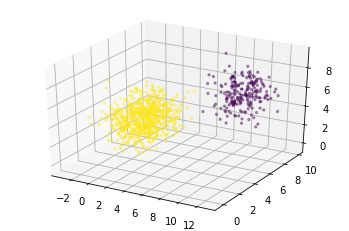

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=labels, marker='.', alpha=0.4)

In [36]:
gmm = GaussianMixture(n_components=N, covariance_type='diag', n_init=10)

In [37]:
gmm.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=10, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [38]:
from sklearn.metrics import adjusted_rand_score

In [39]:
adjusted_rand_score(labels_true=labels, labels_pred=gmm.predict(X))

1.0

In [40]:
print('The adjusted_rand_score validates the model, against known ground truth labels')
print('to ensure that predictions are correctly grouped, up to permutations.')
print('The above score of 1.0 means the model perfectly separated the data in this example ')
print('- perhaps unsurprisingly given that the clusters were relatively spread out and separable.')
print('I ran the above code with N=10: adjusted_rand_score=0.6138')

The adjusted_rand_score validates the model, against known ground truth labels
to ensure that predictions are correctly grouped, up to permutations.
The above score of 1.0 means the model perfectly separated the data in this example 
- perhaps unsurprisingly given that the clusters were relatively spread out and separable.
I ran the above code with N=10: adjusted_rand_score=0.6138


In [41]:
# Q.8. What assumptions are you making when choosing the clustering algorithm in step 2? Will the
# algorithm still perform well if the data were sampled from a uniform distribution or a radial
# distribution? What clustering algorithm would you choose in these cases?
print('I assumed that the data points were from a mixture of Gaussian distributions.')
print('Also that there were 5 clusters and the covariance matrices were diagonal.')
print('A uniform distribution would lead to points being located within a fixed radius of their centroids.')
print('This is where k-means algorithms are most appropriate.')
print('I\'m not entirely sure what the radial distribution is, a quick googling results in:')
print('\'The general algorithm involves determining how many particles are within a distance of r and r+dr away from a particle.\'')
print('so it would appear that k-means would be appropriate here too.')

I assumed that the data points were from a mixture of Gaussian distributions.
Also that there were 5 clusters and the covariance matrices were diagonal.
A uniform distribution would lead to points being located within a fixed radius of their centroids.
This is where k-means algorithms are most appropriate.
I'm not entirely sure what the radial distribution is, a quick googling results in:
'The general algorithm involves determining how many particles are within a distance of r and r+dr away from a particle.'
so it would appear that k-means would be appropriate here too.


In [43]:
# Q.9. Any final comments?
print('I\'d like to say that I had fun working through these questions.')
print('And that it was a good challenge - Kudos to whoever made it.')

I'd like to say that I had fun working through these questions.
And that it was a good challenge - Kudos to whoever made it.
